In [67]:
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew, moment, mode
import numpy as np

data = open("data.txt")

numbers = data.read().split()

for i in range(len(numbers)):
    num = numbers[i].split('e')
    numbers[i] = float(num[0])*10**int(num[1])
    
numbers = np.array(numbers)
numbers.sort()
print(numbers)

[ 0.1529991   0.27232966  0.76074578  0.90872374  0.95273634  1.2002443
  1.2680482   1.2714239   1.4359174   1.5449431   1.5871035   1.7743476
  1.812202    1.8496823   2.0301783   2.1397368   2.1865593   2.2870913
  2.4604298   2.6103645   2.7034606   2.8206464   2.854255    2.8612028
  2.9315028   2.9466895   3.1197833   3.270571    3.333462    3.3363347
  3.365632    3.467526    3.5071727   3.593769    3.6946768   3.8269638
  3.8291585   3.9699605   4.042076    4.054862    4.251118    4.3217738
  4.3221416   4.4510406   4.5482402   4.7054      4.9740186   5.3448481
  6.282688    6.356499    6.4339682   6.639615    6.6642373   6.7235041
  7.4559352   7.6455447   9.0346949   9.0502428  11.764223   13.039174  ]


In [61]:
print(f"Mean: {round(np.mean(numbers), 3)}")
# unbiased
print(f"Variance(unbiased): {round(np.var(numbers, ddof=1), 3)}")
print(f"Kurtosis(unbiased): {round(kurtosis(numbers, bias=False), 3)}")
print(f"Skew(unbiased): {round(skew(numbers, bias=False), 3)}")
# unbiased
# print(round(sum([(n-np.mean(numbers))**2 for n in numbers]) / (len(numbers) - 1), 3))

Mean: 3.867
Variance(unbiased): 6.814
Kurtosis(unbiased): 2.504
Skew(unbiased): 1.41


[0.0, 1.75, 3.5, 5.25, 7.0, 8.75, 10.5, 13.039174]


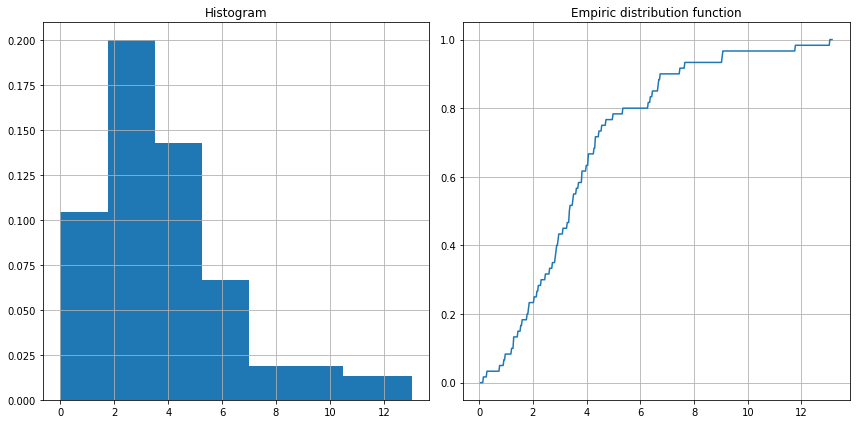

In [102]:
def emp_cdf(x: np.ndarray, sample: np.ndarray):
    f_arr = []
    size = len(sample)
    for i in x:
        freq = (len(sample[sample < i])) / size
        f_arr.append(freq)
    return np.array(f_arr)

def empiric_df(x: np.ndarray):
    return emp_cdf(x, numbers)

left = min(numbers)-0.1
right = max(numbers)+0.1
x = np.linspace(left, right, 500)

f, ax = plt.subplots(1, 2, figsize=(12, 6))

b = list(np.linspace(0, 10.5, 7))
b.extend([max(numbers)])
print(b)
ax[0].hist(numbers, density=True, bins=b)
ax[0].grid()
ax[0].set_title('Histogram')

ax[1].plot(x, empiric_df(x))
ax[1].grid()
ax[1].set_title('Empiric distribution function')

f.tight_layout()

Доверительные полосы:

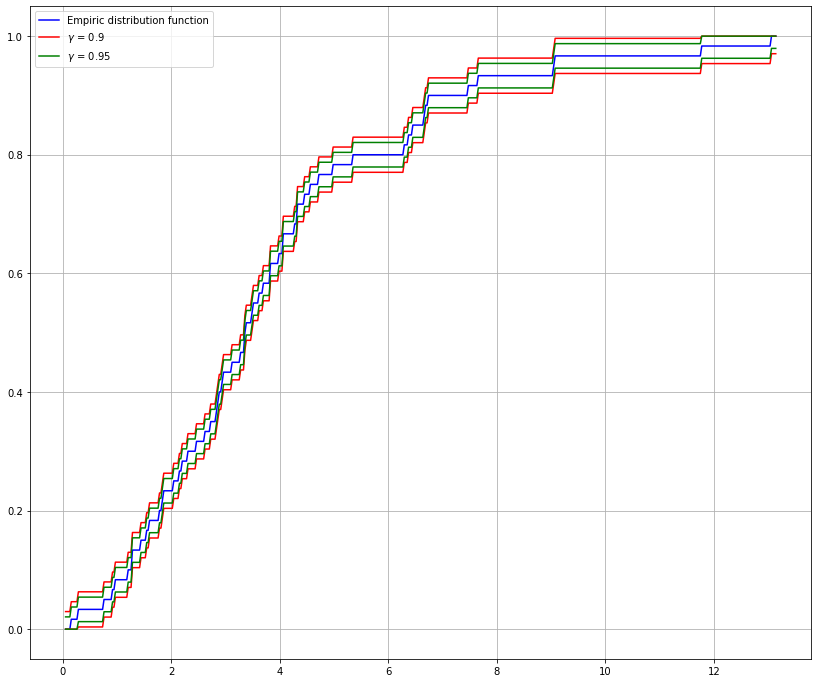

In [83]:
epsilon = lambda alpha: np.sqrt(np.log(1 / alpha) / 2 / len(numbers))
L = lambda alpha: np.array([max(F - epsilon(alpha), 0) for F in empiric_df(x)])
R = lambda alpha: np.array([min(F + epsilon(alpha), 1) for F in empiric_df(x)])

f, ax = plt.subplots(1, 1, figsize=(14, 12))

ax.plot(x, empiric_df(x), color='b', label='Empiric distribution function')

for _, vargamma, clr in zip(range(2), [0.9, 0.95], ['r', 'g']):
    ax.plot(x, L(vargamma), color=clr, label=r"$\gamma$" + f" = {vargamma}")
    ax.plot(x, R(vargamma), color=clr)
    
ax.grid()
ax.legend()

Проверка гипотезы на основе хи-квадрат Фишера:

In [104]:
from scipy.stats import lognorm, gamma
from typing import Union

def theoretic_df_lognorm(x: Union[float, np.ndarray], sigma, mu):
    return lognorm.cdf(x, s=sigma, scale = np.exp(mu))

def theoretic_df_gamma(x: Union[float, np.ndarray], alpha, beta):
    return gamma.cdf(x, a=alpha, scale=beta)

# alpha, beta = 2.194, 1.76
# plt.plot(x, gamma.pdf(x, a=alpha, scale=beta))
# plt.grid()
# plt.show()


# mean, var, skew, kurt = gamma.stats(a=alpha, scale=beta, moments='mvsk')
# print(f"{mean}, {var}, {skew}, {kurt}")

# s = sigma, scale = exp(mu)
# s = 0.72266845
# mean, var, skew, kurt = lognorm.stats(s, scale=np.exp(1.21071559), moments='mvsk')
# print(f"{mean}, {var}, {skew}, {kurt}")


In [56]:
# plt.plot(x, gamma.cdf(x, a=alpha, scale=beta))
# plt.plot(x, empiric_df(x), color='b', label='Empiric distribution function')

# plt.grid()
# plt.show()

In [105]:
def chi2_value(cdf2check, int_num: int, sigma: float, mu: float, nums, logging: bool = False):
    borders = np.linspace(left, right, int_num+1)
    N = len(nums)
    if logging:
        print(f"borders {borders}")
        print(f"sample size: {N}")
    res = 0
    for i in range(int_num):        
        p_k = cdf2check(borders[i+1], sigma, mu) - cdf2check(borders[i], sigma, mu)
        v_k = len([num for num in nums if borders[i] < num and num < borders[i+1]])
        if logging:
            print(f"curr borders: {borders[i], borders[i+1]}")
            print(f"v_k: {v_k}, p_k: {p_k}")
        try:
            res += (v_k - N*p_k)**2 / (N*p_k)
        except Exception:
            print(f"potential zero = {(N*p_k)}")
    
    return res
    

In [111]:
from scipy.optimize import minimize

orders = [7, 10, 15]
chi_4 = 9.4877
chi_7 = 14.0671
chi_12 = 21.0261

# print(chi2_value(10, 0.77231248, 1.26086924, nums=numbers))
theta_lognorm = []
theta_gamma = []
print("lognorm")
for chi, order in zip([chi_4, chi_7, chi_12], orders):
    chi2 = lambda x: chi2_value(theoretic_df_lognorm, order, sigma=x[0], mu=x[1], nums=numbers, logging=False)
    result = minimize(chi2, np.array([1/5, 1.5]), method='TNC', tol=1e-15)
    print(f"Value: {result['fun']}, min: {result['x']}")
    theta_lognorm.append(result['x'])
    print(result['fun'] < chi)
    
print()
print("gamma")
for chi, order in zip([chi_4, chi_7, chi_12], orders):
    chi2 = lambda x: chi2_value(theoretic_df_gamma, order, sigma=x[0], mu=x[1], nums=numbers, logging=False)
    result = minimize(chi2, np.array([2, 1.5]), method='TNC', tol=1e-15)
    print(f"Value: {result['fun']}, min: {result['x']}")
    theta_gamma.append(result['x'])
    print(result['fun'] < chi)

lognorm
Value: 2.9286779826501474, min: [0.73984636 1.22578394]
True
Value: 6.1540022819557, min: [0.72266847 1.21071558]
True
Value: 15.37801796516037, min: [0.77231257 1.26086923]
True

gamma
Value: 3.725067939667958, min: [1.98741174 2.10509303]
True
Value: 5.704264517269577, min: [2.24627287 1.82151617]
True
Value: 14.498600010424962, min: [2.29963691 1.8931506 ]
True


for lognorm: [0.74494247 1.23245625]
for gamma: [2.17777384 1.93991994]


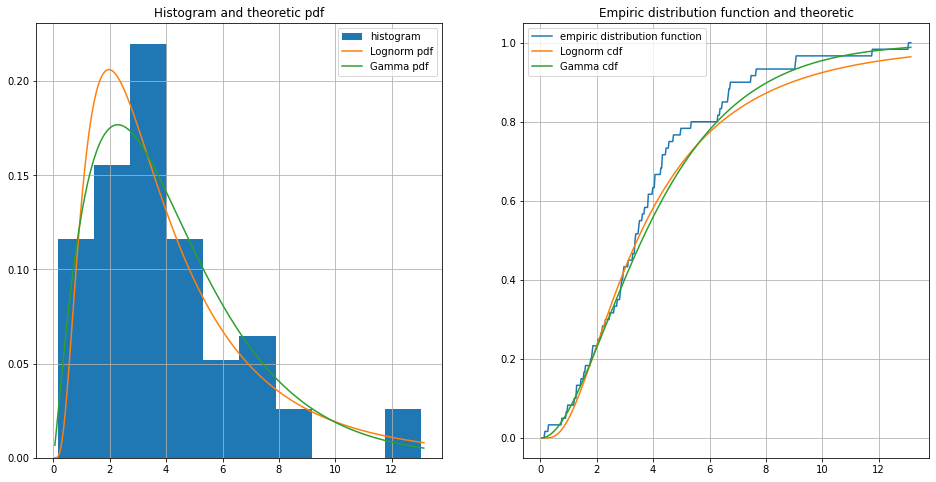

In [112]:
mean_theta_lognorm = np.mean(np.array(theta_lognorm), axis=0)
mean_theta_gamma = np.mean(np.array(theta_gamma), axis=0)
print(f"for lognorm: {mean_theta_lognorm}")
print(f"for gamma: {mean_theta_gamma}")

f, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].hist(numbers, density=True, label='histogram')
ax[0].plot(x, lognorm.pdf(x, s=mean_theta_lognorm[0], scale= np.exp(mean_theta_lognorm[1])), label='Lognorm pdf')
ax[0].plot(x, gamma.pdf(x, a=mean_theta_gamma[0], scale=mean_theta_gamma[1]), label='Gamma pdf')
ax[0].grid()
ax[0].legend()
ax[0].set_title('Histogram and theoretic pdf')

ax[1].plot(x, empiric_df(x), label='empiric distribution function')
ax[1].grid()
ax[1].set_title('Empiric distribution function and theoretic')
ax[1].plot(x, lognorm.cdf(x, s=mean_theta_lognorm[0], scale= np.exp(mean_theta_lognorm[1])), label='Lognorm cdf')
ax[1].plot(x, gamma.cdf(x, a=mean_theta_gamma[0], scale=mean_theta_gamma[1]), label='Gamma cdf')
ax[1].legend()

In [114]:
mean, var, skew, kurt = lognorm.stats(mean_theta_lognorm[0], scale=np.exp(mean_theta_lognorm[1]), moments='mvsk')
print(f"{mean}, {var}, {skew}, {kurt}")

4.526395327207348, 15.19890880632273, 3.2228372955126785, 22.876485533397513


In [115]:
mean, var, skew, kurt = gamma.stats(a=mean_theta_gamma[0], scale=mean_theta_gamma[1], moments='mvsk')
print(f"{mean}, {var}, {skew}, {kurt}")

4.224706882977628, 8.195593104599743, 1.3552630803635581, 2.7551070254947803
